In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor='dimgray', linewidth=1)

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("data.csv")
df.head()

,No,Profile,Date,Time,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU,Status,Unnamed: 22
0,1,BANDUNG,2019-05-19,00:04:19,21.35,0.78,6.77,14.06,26.168,409.86,251.202,0.0,0.0,0.0,2.77,0.0,21.4,100.0,0.600,5,9,GOOD,NaN
1,2,BANDUNG,2019-05-19,00:15:01,5.93,0.82,14.87,17.23,53.853,394.79,501.356,0.0,0.0,0.0,11.95,0.0,42.6,200.0,0.000,2,12,GOOD,NaN
2,3,BANDUNG,2019-05-19,00:30:06,6.62,0.63,22.24,2.31,38.304,390.66,753.291,0.0,0.0,0.0,12.71,0.0,63.6,299.2,0.000,2,13,GOOD,NaN
3,4,BANDUNG,2019-05-19,00:49:19,13.29,0.44,19.00,5.32,18.962,401.23,251.043,0.0,0.0,0.0,1.20,0.0,21.3,88.2,0.525,5,6,GOOD,NaN
4,5,BANDUNG,2019-05-19,01:04:19,2.44,0.47,26.74,13.61,35.270,381.67,250.471,0.0,0.0,0.0,3.52,0.0,21.3,97.4,0.975,5,9,GOOD,NaN


In [4]:
df = df.drop(columns=["No", "Profile", 'Status'])
df.shape

(9231, 20)

In [5]:
# convert TIME to datetime format:
def combine_date(df, tab_name):
    list_tab = []
    for i in range(df.shape[0]):
        list_tab.append(df.loc[i, 'Date'] + 'T' + df.loc[i, tab_name][0:2])
    return np.array(list_tab, dtype='datetime64')

# convert TIME to datetime format:
df['Datetime'] = combine_date(df, 'Time')
df.head()

,Date,Time,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU,Unnamed: 22,Datetime
0,2019-05-19,00:04:19,21.35,0.78,6.77,14.06,26.168,409.86,251.202,0.0,0.0,0.0,2.77,0.0,21.4,100.0,0.600,5,9,NaN,2019-05-19 00:00:00
1,2019-05-19,00:15:01,5.93,0.82,14.87,17.23,53.853,394.79,501.356,0.0,0.0,0.0,11.95,0.0,42.6,200.0,0.000,2,12,NaN,2019-05-19 00:00:00
2,2019-05-19,00:30:06,6.62,0.63,22.24,2.31,38.304,390.66,753.291,0.0,0.0,0.0,12.71,0.0,63.6,299.2,0.000,2,13,NaN,2019-05-19 00:00:00
3,2019-05-19,00:49:19,13.29,0.44,19.00,5.32,18.962,401.23,251.043,0.0,0.0,0.0,1.20,0.0,21.3,88.2,0.525,5,6,NaN,2019-05-19 00:00:00
4,2019-05-19,01:04:19,2.44,0.47,26.74,13.61,35.270,381.67,250.471,0.0,0.0,0.0,3.52,0.0,21.3,97.4,0.975,5,9,NaN,2019-05-19 01:00:00


In [6]:
# convert into hourly data
df = df[['Datetime','O3','CO','NO2','SO2','NO','CO2','VOC','PM1','PM2.5','PM4','PM10','TSP','TEMP','HUM','WS','WD','ISPU']]
df2 = df.groupby(['Datetime']).mean()
df2.head()

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
Datetime,,,,,,,,,,,,,,,,,
2019-05-19 00:00:00,11.797500,0.667500,15.720,9.7300,34.32175,399.135000,439.22300,0.0,0.0,0.0,7.157500,0.0,37.225000,171.850000,0.28125,3.500000,10.000000
2019-05-19 01:00:00,3.816667,0.373333,22.600,20.0900,39.82100,388.536667,250.39400,0.0,0.0,0.0,3.293333,0.0,20.966667,95.033333,0.67500,4.666667,12.666667
2019-05-19 02:00:00,6.450000,0.332500,24.130,26.3100,51.29325,396.242500,251.04575,0.0,0.0,0.0,6.487500,0.0,20.150000,97.500000,0.09375,3.750000,16.250000
2019-05-19 03:00:00,4.740000,0.180000,25.975,24.3900,43.51850,401.355000,252.24875,0.0,0.0,0.0,4.700000,0.0,19.850000,100.000000,0.07500,5.000000,15.000000
2019-05-19 04:00:00,19.692500,0.202500,20.395,18.6225,53.37925,399.335000,694.23975,0.0,0.0,0.0,5.262500,0.0,53.475000,272.500000,0.18750,5.250000,13.250000


In [7]:
# information about dataset after processing
df2.describe(include="all")

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
count,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000
mean,8.538909,0.233172,16.681910,12.013894,37.086256,394.616480,260.053778,0.309564,0.383692,0.451982,6.157770,0.562012,25.266942,77.634191,24.291226,7.129031,10.097848
std,3.997292,0.388102,5.373487,4.411251,12.521778,4.180224,60.773321,2.286104,2.874126,3.378291,4.149511,4.184787,6.707977,29.743129,51.993683,3.523245,5.049788
min,0.270000,0.010000,2.040000,2.162500,3.128750,380.420000,187.518000,0.000000,0.000000,0.000000,0.885000,0.000000,11.250000,26.866667,0.000000,0.000000,4.250000
25%,5.881667,0.083333,13.010000,9.015000,28.443500,391.830000,247.798333,0.000000,0.000000,0.000000,4.340000,0.000000,21.266667,57.850000,0.237500,4.666667,8.166667
50%,7.813333,0.160000,15.916667,11.730000,39.252250,394.602000,250.926250,0.000000,0.000000,0.000000,5.571667,0.000000,24.100000,77.083333,1.312500,5.833333,9.500000
75%,10.373333,0.296667,19.935000,14.595000,46.015500,397.415000,253.286667,0.000000,0.000000,0.000000,7.090000,0.000000,28.400000,94.066667,5.075000,10.500000,11.000000
max,33.741667,13.950000,99.600000,46.290000,194.554000,408.820000,1240.713500,51.600000,68.700000,79.800000,91.600000,92.900000,124.600000,313.400000,199.200000,15.000000,156.500000


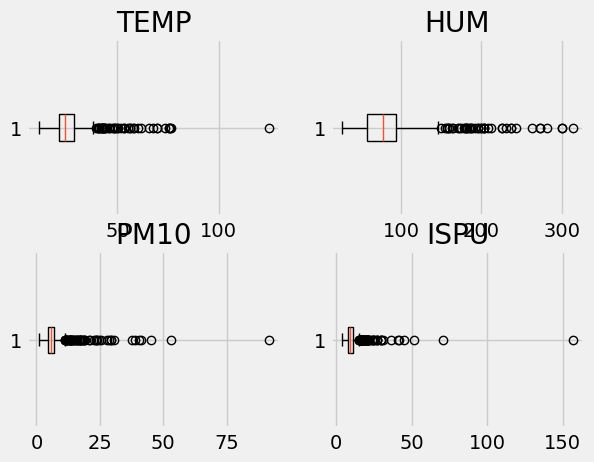

In [8]:
figure, axis = plt.subplots(2, 2) 

axis[0,0].boxplot(df2['TEMP'], vert=False)
axis[0,0].set_title('TEMP')

axis[0,1].boxplot(df2['HUM'], vert=False)
axis[0,1].set_title('HUM')

axis[1,0].boxplot(df2['PM10'], vert=False)
axis[1,0].set_title('PM10')

axis[1,1].boxplot(df2['ISPU'], vert=False)
axis[1,1].set_title('ISPU')

plt.show()

In [9]:
# calculate quantiles from each attributes
def calculate_quantiles(i, df2):
    Q1 = df2[[i]].quantile(0.25)[0]
    Q3 = df2[[i]].quantile(0.75)[0]
    IQR = Q3 - Q1
    min = df2[[i]].min()[0]
    max = df2[[i]].max()[0]
    min_IQR = Q1 - 1.5*IQR
    max_IQR = Q3 + 1.5*IQR
    
    return Q1, Q3, min, max, min_IQR, max_IQR

# delete first and last rows to avoid missing value extrapolation
df2.drop(index=[df2.index[0], df2.index[df2.shape[0]-1]], inplace=True)

# find and interpolate the outliers
for column in df2.columns:
    print('\nAttribute-', column,':')
    Q1, Q3, min, max, min_IQR, max_IQR = calculate_quantiles(column, df2)
    print('Q1 = %.2f' % Q1)
    print('Q3 = %.2f' % Q3)
    print('min = %.2f' % min)
    print('max = %.2f' % max)
    print('min IQR = %.2f' % min_IQR)
    print('max IQR = %.2f' % max_IQR)
    
    if (min < min_IQR):
        print('---> Low outlier is found = %.2f' % min)

    if (max > max_IQR):
        print('---> High outlier is found = %.2f' % max)
    
    def convert_nan (x, max_IQR=max_IQR, min_IQR=min_IQR):
        if ((x > max_IQR) | (x < min_IQR)):
            x = np.nan
        else:
            x = x
        return x

    def convert_nan_HUM (x, max_IQR=100.0, min_IQR=min_IQR):
        if ((x > max_IQR) | (x < min_IQR)):
            x = np.nan
        else:
            x = x
        return x

    if (column == 'HUM'):
        df2[column] = df2[column].map(convert_nan_HUM)
        df2[column] = df2[column].interpolate(method='linear')

    if (column != 'HUM'):
        df2[column] = df2[column].map(convert_nan)
        df2[column] = df2[column].interpolate(method='linear')
    
    if (len(df2[df2[column].isnull()][column]) == 0):
        print('################  Outliers have been interpolated  ################')


Attribute- O3 :
Q1 = 5.88
Q3 = 10.37
min = 0.27
max = 33.74
min IQR = -0.85
max IQR = 17.10
---> High outlier is found = 33.74
################  Outliers have been interpolated  ################

Attribute- CO :
Q1 = 0.08
Q3 = 0.30
min = 0.01
max = 13.95
min IQR = -0.24
max IQR = 0.62
---> High outlier is found = 13.95
################  Outliers have been interpolated  ################

Attribute- NO2 :
Q1 = 13.01
Q3 = 19.93
min = 2.04
max = 99.60
min IQR = 2.62
max IQR = 30.32
---> Low outlier is found = 2.04
---> High outlier is found = 99.60
################  Outliers have been interpolated  ################

Attribute- SO2 :
Q1 = 9.00
Q3 = 14.61
min = 2.16
max = 46.29
min IQR = 0.60
max IQR = 23.01
---> High outlier is found = 46.29
################  Outliers have been interpolated  ################

Attribute- NO :
Q1 = 28.44
Q3 = 46.02
min = 3.13
max = 194.55
min IQR = 2.09
max IQR = 72.37
---> High outlier is found = 194.55
################  Outliers have been interpolated  ###

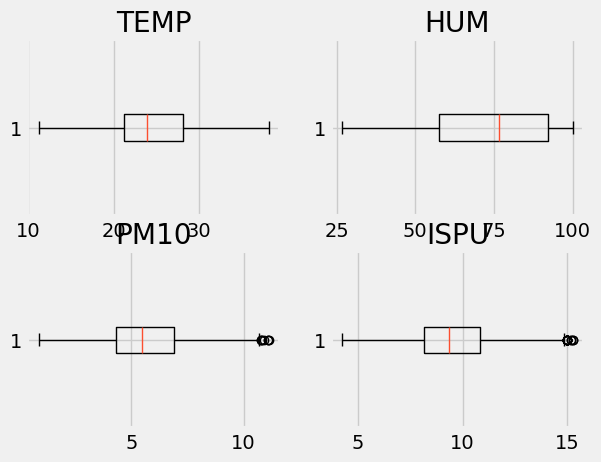

In [19]:
figure, axis = plt.subplots(2, 2) 

axis[0,0].boxplot(df2['TEMP'], vert=False)
axis[0,0].set_title('TEMP')

axis[0,1].boxplot(df2['HUM'], vert=False)
axis[0,1].set_title('HUM')

axis[1,0].boxplot(df2['PM10'], vert=False)
axis[1,0].set_title('PM10')

axis[1,1].boxplot(df2['ISPU'], vert=False)
axis[1,1].set_title('ISPU')

plt.show()

# Temperature Prediction

In [10]:
# log transformation to deal with skewed data

temp_dataset = np.log1p(df2[['TEMP']].values)
temp_dataset.shape

(1735, 1)

<Figure size 1200x500 with 0 Axes>

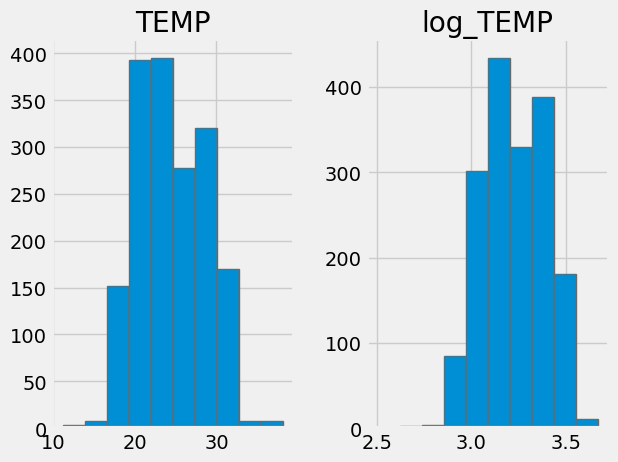

In [11]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'TEMP' : df2['TEMP'].values, 'log_TEMP' : temp_dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [12]:
# Split train and test data
temp_train_sz = int(len(temp_dataset) * 0.8)
temp_test_sz = int(len(temp_dataset)) - temp_train_sz

temp_train, temp_test = temp_dataset[0: temp_train_sz,:], temp_dataset[temp_train_sz: len(temp_dataset),:]

print(len(temp_train), len(temp_test))

1388 347


In [13]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(temp_train, look_back)
testX, testY = create_dataset(temp_test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (1386, 1)
Shape of trainY : (1386,)
Shape of testX : (345, 1)
Shape of testY : (345,)


In [14]:
# reshape the input array to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (1386, 1, 1)
Shape of testX : (345, 1, 1)


In [15]:
# create and fit the LSTM Neural Network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1500, batch_size=32, verbose=2)



Epoch 1/1500

44/44 - 15s - loss: 9.7975 - 15s/epoch - 345ms/step
Epoch 2/1500
44/44 - 0s - loss: 9.1128 - 214ms/epoch - 5ms/step
Epoch 3/1500
44/44 - 0s - loss: 8.3415 - 199ms/epoch - 5ms/step
Epoch 4/1500
44/44 - 0s - loss: 7.4387 - 189ms/epoch - 4ms/step
Epoch 5/1500
44/44 - 0s - loss: 6.4137 - 189ms/epoch - 4ms/step
Epoch 6/1500
44/44 - 0s - loss: 5.3303 - 199ms/epoch - 5ms/step
Epoch 7/1500
44/44 - 0s - loss: 4.2816 - 206ms/epoch - 5ms/step
Epoch 8/1500
44/44 - 0s - loss: 3.3412 - 270ms/epoch - 6ms/step
Epoch 9/1500
44/44 - 0s - loss: 2.5496 - 221ms/epoch - 5ms/step
Epoch 10/1500
44/44 - 0s - loss: 1.9122 - 213ms/epoch - 5ms/step
Epoch 11/1500
44/44 - 0s - loss: 1.4135 - 363ms/epoch - 8ms/step
Epoch 12/1500
44/44 - 0s - loss: 1.0315 - 265ms/epoch - 6ms/step
Epoch 13/1500
44/44 - 0s - loss: 0.7430 - 251ms/epoch - 6ms/step
Epoch 14/1500
44/44 - 1s - loss: 0.5281 - 506ms/epoch - 12ms/step
Epoch 15/1500
44/44 - 0s - loss: 0.3701 - 237ms/epoch - 5ms/step
Epoch 16/1500
44/44 - 0s - lo

## Model Performance

In [16]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

11/11 [==============================] - 0s 6ms/step
Train Score: 2.32 RMSE
Test Score: 3.44 RMSE


In [17]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
3.44 < 4.42


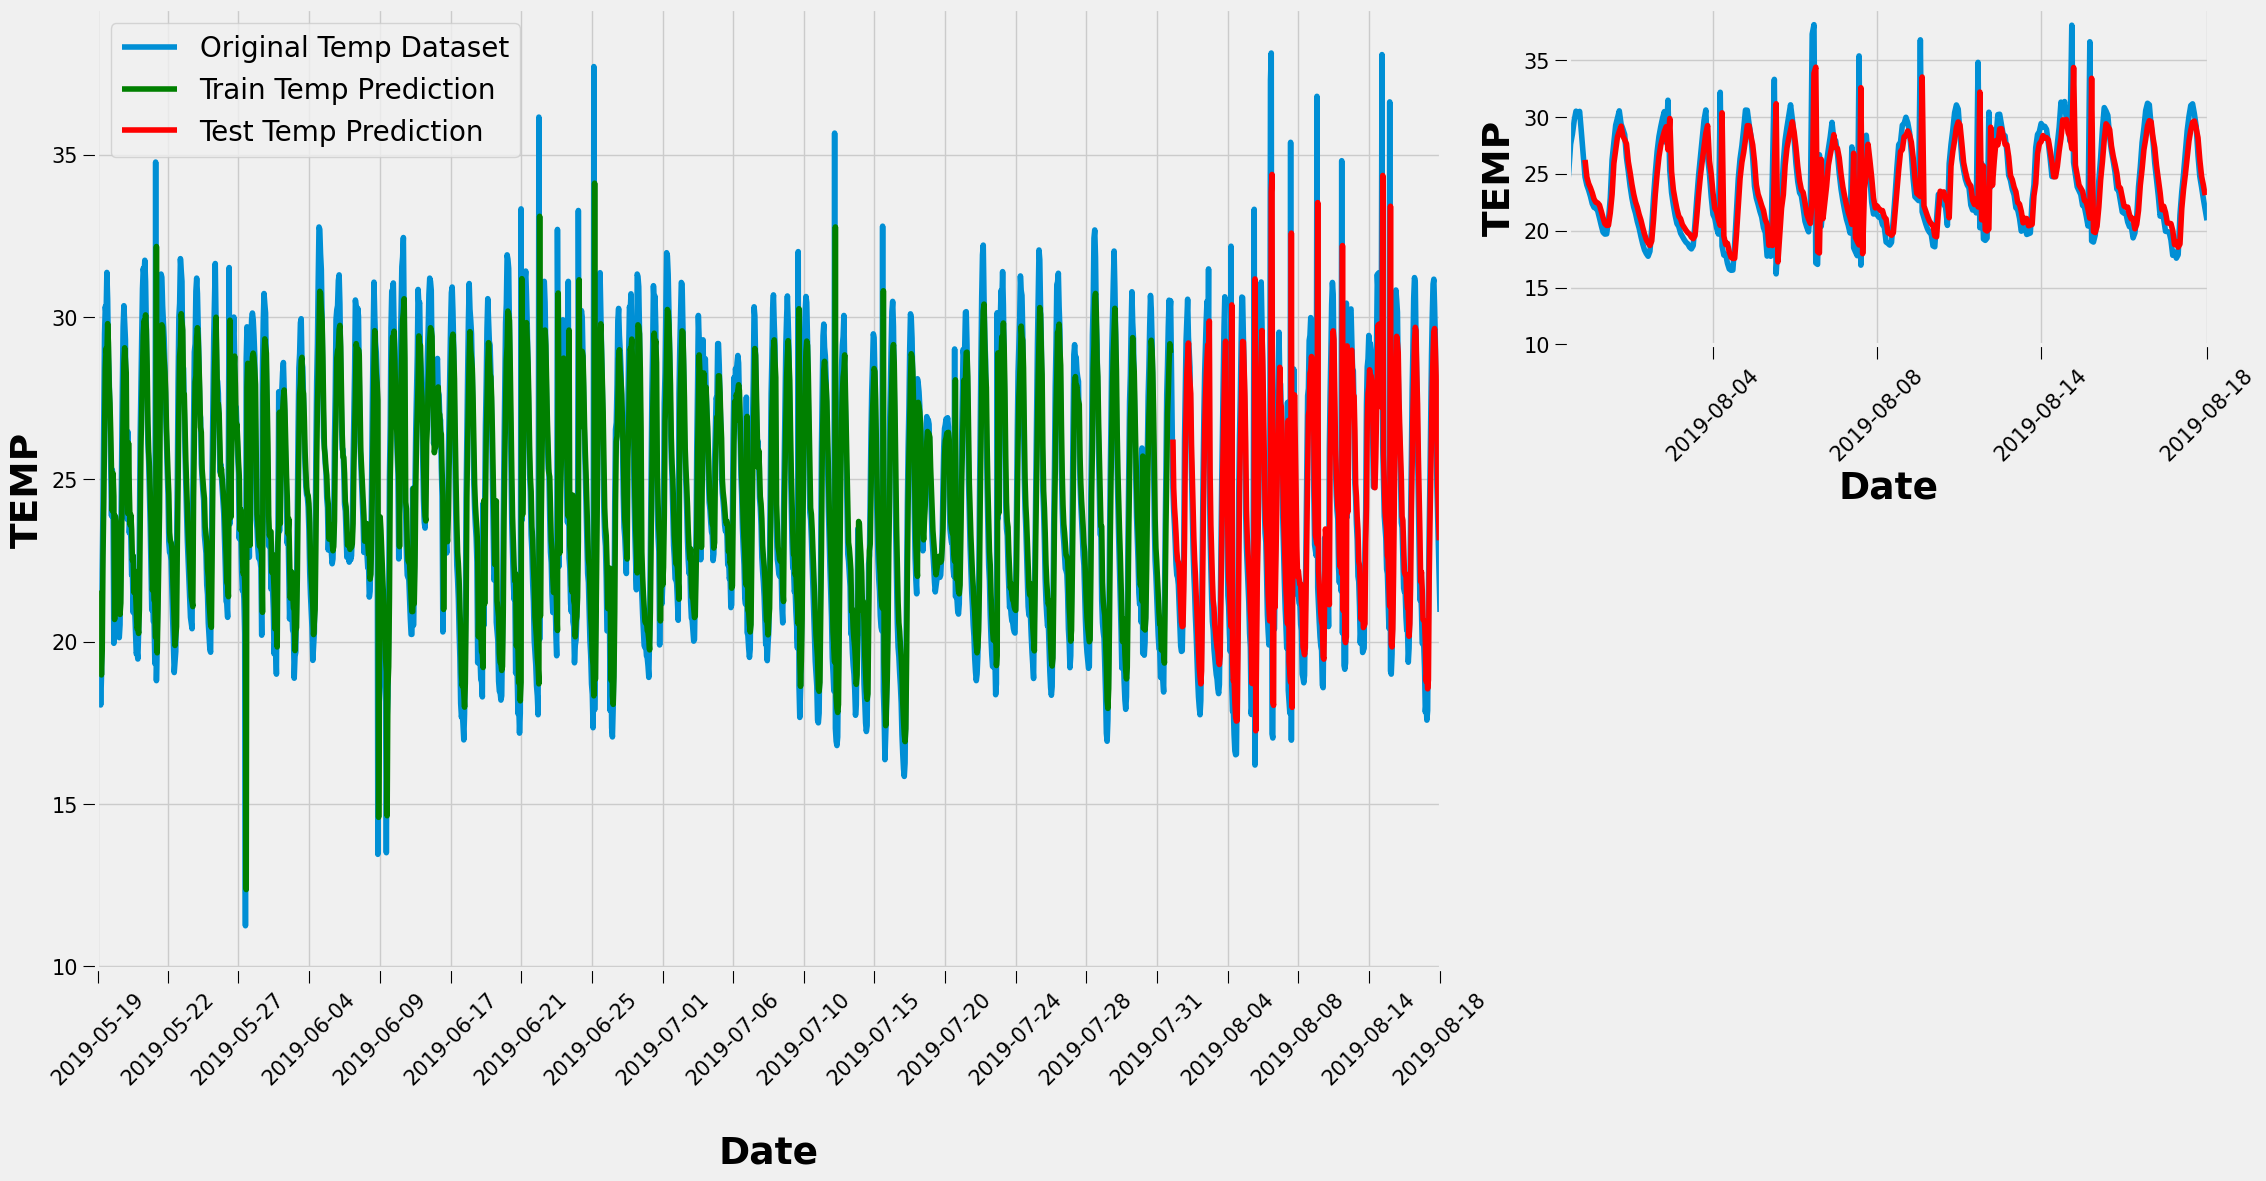

In [18]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(temp_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(temp_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(temp_dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, temp_dataset.shape[0]-1, 20)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(df2.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(temp_dataset), label='Original Temp Dataset')
ax.plot(trainPredictPlot, color='green', label='Train Temp Prediction')
ax.plot(testPredictPlot, color='red', label='Test Temp Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('TEMP', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(temp_dataset), label='Original Temp Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Temp Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('TEMP', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1380,1735]);